# Lab Three: Clustering

Matt Farrow, Amber Clark, Blake Freeman, Megan Ball

## **2015 Flight Delays and Cancellations**
Data Source: [Kaggle](https://www.kaggle.com/usdot/flight-delays?select=flights.csv)

Our data set consists of over 5 million rows of flight information in the domestic United States for the year of 2015. In order to optimize our modeling time, we have narrowed the scope of our classification tasks to the Dallas area only (Dallas Love Field and DFW airports). 

## Rubric

### [Business Understanding](#Business-Understanding) (10 points total)

- [10 points] Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

### [Data Understanding](#Data-Understanding) (20 points total)

#### [Data Understanding 1](#Data-Understanding-1)

- [10 points] Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

#### [Data Understanding 2](#Data-Understanding-2)

- [10 points] Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

### [Modeling and Evaluation](#Modeling-and-Evaluation) (50 points total)

Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results.

#### Option A: Cluster Analysis

- Perform cluster analysis using several clustering methods
- How did you determine a suitable number of clusters for each method?
- Use internal and/or external validation measures to describe and compare the clusterings and the clusters (some visual methods would be good).
- Describe your results. What findings are the most interesting and why?

#### [Modeling and Evaluation 1](#Modeling-and-Evaluation-1)

- Train and adjust parameters

#### [Modeling and Evaluation 2](#Modeling-and-Evaluation-2)

- Evaluate and compare

#### [Modeling and Evaluation 3](#Modeling-and-Evaluation-3)

- Visualize results

#### [Modeling and Evaluation 4](#Modeling-and-Evaluation-4)

- Summarise the ramifications

### [Deployment](#Deployment) (10 points total)

Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?

- How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
- How would your deploy your model for interested parties?
- What other data should be collected?
- How often would the model need to be updated, etc.?

### [Exceptional Work](#Exceptional-Work) (10 points total)

You have free reign to provide additional analyses or combine analyses.

# Business Understanding
Jump to [top](#Rubric)

# Data Understanding
Jump to [top](#Rubric)

## Data Understanding 1
Jump to [top](#Rubric)

> Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

The initial data pre-processing has already been covered in Labs 1, 2, and the Mini-Lab. Here we have collapsed our code as much as possible.

In [28]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#from datetime import datetime
import altair as alt
import datetime

# Machine learning
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## [Jump to Clean Data](#Final-Data-Set)

Clicking this link will skip over the cleanup work and let you get started with the final data set. 

In [29]:
import warnings
warnings.filterwarnings('ignore')

# Due to the way these columns are formatted, we want to keep the leading zeros during our import. 
# Later on will convert them to a time format.
dtype_t = {'SCHEDULED_DEPARTURE': str,
           'DEPARTURE_TIME': str,
           'WHEELS_OFF': str,
           'SCHEDULED_TIME': str,
           'WHEELS_ON': str,
           'SCHEDULED_ARRIVAL': str,
           'ARRIVAL_TIME': str
          }

# Read in the data directly
airlines = pd.read_csv('../Data/airlines.csv')
airports = pd.read_csv('../Data/airports.csv')
flights  = pd.read_csv('../Data/flights.csv', dtype = dtype_t)

# Read in the data directly from GitHub
# airlines = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airlines.csv')
# airports = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airports.csv')
# flights  = pd.read_csv('https://media.githubusercontent.com/media/mattfarrow1/7331-machine-learning-1/main/Data/flights.csv', dtype = dtype_t)

# Rename columns in preparation for merge
airlines.rename(columns={'IATA_CODE': 'AIRLINE_CODE'}, inplace=True)
flights.rename(columns={'AIRLINE': 'AIRLINE_CODE'}, inplace=True)

# Merge data together
df = pd.merge(flights, airlines, on='AIRLINE_CODE', how = 'left')

# Subset to DFW Area
df = df[(df.ORIGIN_AIRPORT == 'DFW') | (df.ORIGIN_AIRPORT == 'DAL')]

#### Create New Variables

In [30]:
# Convert times into buckets for morning, afternoon, and evening as most models cannot handle timestamps.
cut_labels = ['overnight', 'morning', 'afternoon', 'evening']
cut_bins = [0, 600, 1200, 1800, 2359]

df['SCHED_DEPARTURE_TIME'] = pd.cut(df['SCHEDULED_DEPARTURE'].astype(float), 
                                    bins=cut_bins, 
                                    labels=cut_labels, 
                                    include_lowest=True)
df['ACTUAL_DEPARTURE_TIME'] = pd.cut(df['DEPARTURE_TIME'].astype(float), 
                                     bins=cut_bins, 
                                     labels=cut_labels, 
                                     include_lowest=True)
df['SCHED_ARRIVAL_TIME'] = pd.cut(df['SCHEDULED_ARRIVAL'].astype(float), 
                                  bins=cut_bins, 
                                  labels=cut_labels, 
                                  include_lowest=True)
df['ACTUAL_ARRIVAL_TIME'] = pd.cut(df['ARRIVAL_TIME'].astype(float), 
                                  bins=cut_bins, 
                                  labels=cut_labels, 
                                  include_lowest=True)

# Bucket Flight Distance
distance_labels = ['Short', 'Medium', 'Long']
distance_bins   = [1, 100, 1000, np.inf]
df['DISTANCE_BUCKET'] = pd.cut(df['DISTANCE'],
                               bins=distance_bins,
                               labels=distance_labels)

# Create a new column where the arrival_delay > 0 means it's delayed(=1) and if <= 0 it's not delayed(=0)
get_delay = lambda x: 0 if x <= 0 else 1
df['DELAYED'] = df.ARRIVAL_DELAY.apply(get_delay)

# Look at our data with the buckets
pd.set_option('display.max_columns', None)
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,DELAYED
70,2015,1,1,4,AA,1057,N3ASAA,DFW,MIA,0515,0703,108.0,15.0,0718,161,155.0,133.0,1121,1031,7.0,0856,1038,102.0,0,0,NaN,0.0,0.0,0.0,0.0,102.0,American Airlines Inc.,overnight,morning,morning,morning,Long,1
124,2015,1,1,4,DL,1890,N377DA,DFW,ATL,0545,0603,18.0,13.0,0616,124,104.0,86.0,731,0842,5.0,0849,0847,-2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Delta Air Lines Inc.,overnight,morning,morning,morning,Medium,0
203,2015,1,1,4,AA,72,N5EKAA,DFW,MCO,0600,0606,6.0,18.0,0624,145,142.0,120.0,985,0924,4.0,0925,0928,3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,morning,morning,morning,Medium,1
209,2015,1,1,4,AA,1100,N3GWAA,DFW,LGA,0600,0554,-6.0,33.0,0627,190,191.0,154.0,1389,1001,4.0,1010,1005,-5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,overnight,morning,morning,Long,0
310,2015,1,1,4,MQ,3015,N825MQ,DFW,BTR,0600,NaN,NaN,NaN,NaN,78,NaN,NaN,383,NaN,NaN,0718,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN,American Eagle Airlines Inc.,overnight,NaN,morning,NaN,Medium,1


#### Process Dates & Time

In [31]:
# Source: https://stackoverflow.com/questions/54487059/pandas-how-to-create-a-single-date-column-from-columns-containing-year-month
df['FLIGHT_DATE'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(df.YEAR, df.MONTH, df.DAY)])

# Creating a function to change the way of representation of time in the column
def fun_format_time(hours):
        if hours == 2400:
            hours = 0
        else:
            hours = "{0:04d}".format(int(hours))
            Hourmin = datetime.time(int(hours[0:2]), int(hours[2:4]))
            return Hourmin

In [32]:
# Define the time columns
cols = ["SCHEDULED_DEPARTURE", 
        "DEPARTURE_TIME", 
        "SCHEDULED_ARRIVAL", 
        "ARRIVAL_TIME",
        "WHEELS_ON",
        "WHEELS_OFF"]

# Convert times to float in order to correctly process them through the function
df[cols] = df[cols].astype(float)

# Run times through the new function
# Code adapted from: https://stackoverflow.com/questions/35232705/how-to-test-for-nans-in-an-apply-function-in-pandas
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['DEPARTURE_TIME']      = df['DEPARTURE_TIME'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['SCHEDULED_ARRIVAL']   = df['SCHEDULED_ARRIVAL'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['ARRIVAL_TIME']        = df['ARRIVAL_TIME'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['WHEELS_ON']           = df['WHEELS_ON'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['WHEELS_OFF']          = df['WHEELS_OFF'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)

# Combine date & time for departure and arrival
# Source: https://stackoverflow.com/questions/17978092/combine-date-and-time-columns-using-python-pandas
df['SCHEDULED_DEPARTURE_DT'] = pd.to_datetime(df['FLIGHT_DATE'].astype(str) + ' ' + df['SCHEDULED_DEPARTURE'].astype(str))
df['SCHEDULED_ARRIVAL_DT']   = pd.to_datetime(df['FLIGHT_DATE'].astype(str) + ' ' + df['SCHEDULED_ARRIVAL'].astype(str))

#### Append Dallas-Area Weather

In [33]:
# Read in the data
import datetime
weather = pd.read_csv('../Data/dfw_weather.csv')
weather['dt_iso'] = weather['dt_iso'].astype(str)

# Remove "+0000 UTC"
weather['dt_iso_update'] = weather['dt_iso'].str.split('+').str[0]

# Convert new column to a datetime type
weather['date_time'] =  pd.to_datetime(weather['dt_iso_update'], format='%Y-%m-%d %H:%M')

weather['date_time'] = weather['date_time'].dt.round('30min')  
df['SCHEDULED_DEPARTURE_DT'] = df['SCHEDULED_DEPARTURE_DT'].dt.round('30min')

df = pd.merge(df, weather, left_on='SCHEDULED_DEPARTURE_DT', right_on='date_time')

# Remove unnecessary columns from weather data
col_to_drop = ['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'feels_like', 'temp_min', 'temp_max',
              'sea_level', 'grnd_level', 'dt_iso_update', 'weather_icon', 'weather_description', 'date_time']
df = df.drop(columns = col_to_drop)

#### Missing Values

In [34]:
# Remove non-critical columns WHEELS_ON and WHEELS_OFF
df = df.drop(['WHEELS_ON','WHEELS_OFF'], axis=1)

# Add category
df['ACTUAL_DEPARTURE_TIME'] = df['ACTUAL_DEPARTURE_TIME'].cat.add_categories(['N'])
df['ACTUAL_ARRIVAL_TIME'] = df['ACTUAL_ARRIVAL_TIME'].cat.add_categories(['N'])

# Fill missing values with 'N' for 'N/A'
df['ACTUAL_DEPARTURE_TIME'] = df['ACTUAL_DEPARTURE_TIME'].fillna('N')
df['ACTUAL_ARRIVAL_TIME'] = df['ACTUAL_ARRIVAL_TIME'].fillna('N')

# Convert missing values to 'N' for 'N/A'
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('N')

# Update missing values in times to 0. 
# Will be updating times to a binary (1 = yes action happened, 0 = no action happened)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].fillna(0)

# Change all non-null values to 1
df.loc[(df.DEPARTURE_TIME != '0'), 'DEPARTURE_TIME'] = 1

# Change column name to 'DEPARTED'
df.rename(columns={'DEPARTURE_TIME': 'DEPARTED'}, inplace=True)

# Update remaining columns using same logic
cols = ['ARRIVAL_TIME']
df[cols] = df[cols].fillna(0)
df.loc[(df.ARRIVAL_TIME != '0'), 'ARRIVAL_TIME'] = 1
df.rename(columns={'ARRIVAL_TIME': 'ARRIVED'}, inplace=True)

# Fill missing values with 0
cols = ['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY', 
       'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h']
df[cols] = df[cols].fillna(0)

# Change remaining null values to 0 if flight was cancelled
df.loc[(df.CANCELLED == 1), ('DEPARTURE_DELAY', 'TAXI_OUT', 'ELAPSED_TIME','AIR_TIME','TAXI_IN','ARRIVAL_DELAY')] = 0

# Drop remaining missing values and check total cancels left
df = df.dropna()

# Delete date columns ahead of modeling
df = df.drop(columns = ['FLIGHT_DATE', 'SCHEDULED_DEPARTURE_DT', 'SCHEDULED_ARRIVAL_DT'])

# Convert back to string
df.SCHEDULED_DEPARTURE = df.SCHEDULED_DEPARTURE.astype(str)
df.SCHEDULED_ARRIVAL = df.SCHEDULED_ARRIVAL.astype(str)

# Remove colons
df.SCHEDULED_DEPARTURE = df.SCHEDULED_DEPARTURE.str.replace(r'\D+', '')
df.SCHEDULED_ARRIVAL = df.SCHEDULED_ARRIVAL.str.replace(r'\D+', '')

# Convert to float
df.SCHEDULED_DEPARTURE = df.SCHEDULED_DEPARTURE.astype(int)
df.SCHEDULED_ARRIVAL = df.SCHEDULED_ARRIVAL.astype(int)

#### Log Transformations

In [35]:
print("Min DEPARTURE_DELAY", min(df["DEPARTURE_DELAY"]))
print("Min ARRIVAL_DELAY", min(df["ARRIVAL_DELAY"]))
print("Min DISTANCE", min(df["DISTANCE"]))
print("Min TAXI_IN", min(df["TAXI_IN"]))
print("Min ELAPSED_TIME", min(df["ELAPSED_TIME"]))
print("Min AIR_TIME", min(df["AIR_TIME"]))

Min DEPARTURE_DELAY -24.0
Min ARRIVAL_DELAY -56.0
Min DISTANCE 89
Min TAXI_IN 0.0
Min ELAPSED_TIME 0.0
Min AIR_TIME 0.0


In [36]:
# Log transformation keeping the 0 in the data sets. Because we have negative values, need to offset to make minimum
# equal to zero and not a negative number. For the other vars, no need to run lambda function as min > 0 which improves
# run time
df["DEPARTURE_DELAY_log"] = df["DEPARTURE_DELAY"].map(lambda i: np.log(i + 24) if i != -24 else 0) 
df["ARRIVAL_DELAY_log"]   = df["ARRIVAL_DELAY"].map(lambda i: np.log(i + 56) if i != -56 else 0)
df["DISTANCE_log"]        = np.log(df["DISTANCE"])
df["TAXI_IN_log"]         = np.log1p(df["TAXI_IN"])
df["ELAPSED_TIME_log"]    = np.log1p(df["ELAPSED_TIME"])
df["AIR_TIME_log"]        = np.log1p(df["AIR_TIME"])

#### Feature Removals

In [37]:
# Here we remove redundant columns to further reduce the data size. Columns that are being removed:
# `YEAR`: All rows are from 2015, no need to include this.
# `AIRLINE`: We have AIRLINE_CODE which is the same information
col_to_drop1 = ['YEAR','AIRLINE']
df = df.drop(columns = col_to_drop1)

#### Encoding

In [38]:
# Filter out instances where a tail number appears less than 5 times
df = df[df.groupby('TAIL_NUMBER').TAIL_NUMBER.transform(len) > 4]

# Encode Destination Airport & Tail Number
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['DESTINATION_AIRPORT_encode'] = labelencoder.fit_transform(df['DESTINATION_AIRPORT'])
df.dropna(subset = ["DESTINATION_AIRPORT_encode"], inplace=True)
df['TAIL_NUMBER_encode'] = labelencoder.fit_transform(df['TAIL_NUMBER'])

# Drop original columns
col_to_drop2 = ['TAIL_NUMBER','DESTINATION_AIRPORT']
df = df.drop(columns = col_to_drop2)

# One-hot encode categorical columns
categorical_columns = ['AIRLINE_CODE', 'CANCELLATION_REASON', 'SCHED_DEPARTURE_TIME', 
                       'ACTUAL_DEPARTURE_TIME','SCHED_ARRIVAL_TIME', 'ACTUAL_ARRIVAL_TIME',
                       'DISTANCE_BUCKET', 'weather_main', 'ORIGIN_AIRPORT']

for column in categorical_columns:
  tempdf = pd.get_dummies(df[categorical_columns], prefix = categorical_columns, drop_first = True)
  df_OHE = pd.merge(
      left = df,
      right = tempdf,
      left_index=True,
      right_index=True
  )
  df_OHE = df_OHE.drop(columns = categorical_columns)

In [39]:
# Scheduled time needs to be int
df_OHE['SCHEDULED_TIME'] = df_OHE['SCHEDULED_TIME'].astype(int)

#### Flight Delay Response Variable

In [40]:
# Add response variable bucket for delay time for departure
# 0 is Early (negative time)
# 1 is On_Time or between 0 and 10 minutes late
# 2 is Late (between 11 and 30 min late)
# 3 is very late (between 31 and 60 min late)
# 4 is extremely late (over 61 min late)

delay_labels = ['0', '1', '2', '3', '4']
delay_bins   = [-np.inf, -1, 10, 30, 60, np.inf]
df_OHE['DELAY_BUCKET'] = pd.cut(df_OHE['DEPARTURE_DELAY'],
                               bins=delay_bins,
                               labels=delay_labels)

#check counts by bucket
df_OHE['DELAY_BUCKET'].value_counts()

0    99535
1    50033
2    24784
3    13854
4    13030
Name: DELAY_BUCKET, dtype: int64

In [41]:
# Convert from category to int
df_OHE['DELAY_BUCKET'] = df_OHE['DELAY_BUCKET'].astype(int)

# Drop unnecessary columns
col_to_drop3 = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'DISTANCE', 'TAXI_IN', 'ELAPSED_TIME', 'AIR_TIME']
df_OHE = df_OHE.drop(columns = col_to_drop3)

In [42]:
# Create the delay data set
df_delay = df_OHE

In [43]:
# Filter out cancelled flights
df_delay = df_delay[df_delay.CANCELLED == 0]

col_to_drop4 = ['CANCELLED', 
                'CANCELLATION_REASON_B', 
                'CANCELLATION_REASON_C', 
                'CANCELLATION_REASON_N', 
                'ACTUAL_DEPARTURE_TIME_morning', 
                'ACTUAL_DEPARTURE_TIME_afternoon', 
                'ACTUAL_DEPARTURE_TIME_evening',
                'ACTUAL_DEPARTURE_TIME_N',
                'ACTUAL_ARRIVAL_TIME_morning',
                'ACTUAL_ARRIVAL_TIME_afternoon',
                'SCHEDULED_DEPARTURE',
                'SCHEDULED_ARRIVAL',
                'AIR_SYSTEM_DELAY',
                'SECURITY_DELAY', 
                'ACTUAL_ARRIVAL_TIME_evening',
                'ACTUAL_ARRIVAL_TIME_N',
                'AIRLINE_DELAY', 
                'LATE_AIRCRAFT_DELAY', 
                'WEATHER_DELAY', 
                'DELAYED', 
                'DEPARTURE_DELAY_log',
                'ARRIVAL_DELAY_log', 
                'ELAPSED_TIME_log', 
                'DEPARTED', 
                'ARRIVED',
                'TAXI_IN_log',
                'AIR_TIME_log']

df_delay = df_delay.drop(columns = col_to_drop4)

In [44]:
# Drop columns that our correlation matrix from lab 2 indicated were greater than 0.8
col_to_drop7 = ['DISTANCE_log', 'DIVERTED']

df_delay = df_delay.drop(columns = col_to_drop7)

## Data Understanding 2
Jump to [top](#Rubric)

> Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

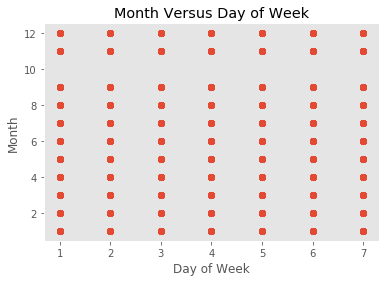

In [62]:
plt.style.use("ggplot")

%matplotlib inline
X1 = df_delay[['MONTH','DAY_OF_WEEK']].values

plt.scatter(X1[:, 1], X1[:, 0])
plt.xlabel('Day of Week'), plt.ylabel('Month')
plt.grid()
plt.title('Month Versus Day of Week')
plt.show()

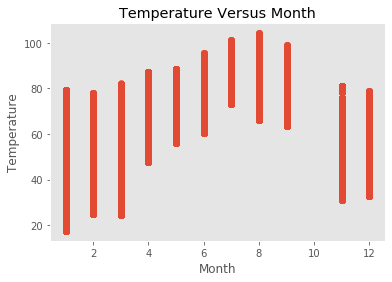

In [64]:
X1 = df_delay[['temp','MONTH']].values

plt.scatter(X1[:, 1], X1[:, 0])
plt.xlabel('Month'), plt.ylabel('Temperature')
plt.grid()
plt.title('Temperature Versus Month')
plt.show()

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201236 entries, 0 to 204226
Data columns (total 52 columns):
MONTH                         201236 non-null int64
DAY                           201236 non-null int64
DAY_OF_WEEK                   201236 non-null int64
AIRLINE_CODE                  201236 non-null object
FLIGHT_NUMBER                 201236 non-null int64
ORIGIN_AIRPORT                201236 non-null object
SCHEDULED_DEPARTURE           201236 non-null int32
DEPARTED                      201236 non-null int64
DEPARTURE_DELAY               201236 non-null float64
TAXI_OUT                      201236 non-null float64
SCHEDULED_TIME                201236 non-null object
ELAPSED_TIME                  201236 non-null float64
AIR_TIME                      201236 non-null float64
DISTANCE                      201236 non-null int64
TAXI_IN                       201236 non-null float64
SCHEDULED_ARRIVAL             201236 non-null int32
ARRIVED                       201236 non-nul

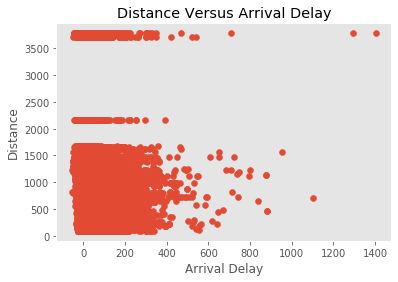

In [66]:
X1 = df[['DISTANCE','ARRIVAL_DELAY']].values

plt.scatter(X1[:, 1], X1[:, 0])
plt.xlabel('Arrival Delay'), plt.ylabel('Distance')
plt.grid()
plt.title('Distance Versus Arrival Delay')
plt.show()

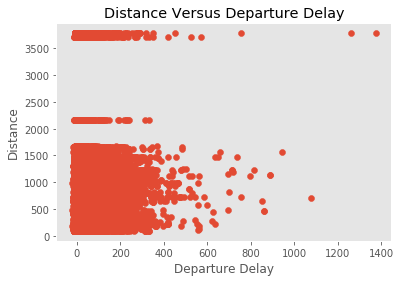

In [67]:
X1 = df[['DISTANCE','DEPARTURE_DELAY']].values

plt.scatter(X1[:, 1], X1[:, 0])
plt.xlabel('Departure Delay'), plt.ylabel('Distance')
plt.grid()
plt.title('Distance Versus Departure Delay')
plt.show()

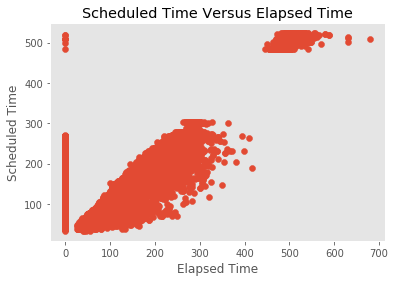

In [70]:
df['SCHEDULED_TIME'] = df['SCHEDULED_TIME'].astype(int)

X1 = df[['SCHEDULED_TIME','ELAPSED_TIME']].values

plt.scatter(X1[:, 1], X1[:, 0])
plt.xlabel('Elapsed Time'), plt.ylabel('Scheduled Time')
plt.grid()
plt.title('Scheduled Time Versus Elapsed Time')
plt.show()

### Final Data Set

The delay data set contains basic flight information from our original data plus weather data for the appropriate date & time of each flight, encoded variables for `DESTINATION_AIRPORT` and `TAIL_NUMBER`, and one-hot encoded airline codes.
Newly created variables included buckets for the flight’s scheduled departure and arrival times (morning, afternoon, and evening), distance (medium and long), and a response variable `DELAY_BUCKET` that groups delay times by length of delay in minutes.
- **Early** is defined as 0 and is any value where the `DEPARTURE_DELAY` is < 0.
- **On-Time** is defined as 1 and is any value where 0 <= `DEPARTURE_DELAY` <= 10
- **Late** is defined as 2 and is any value where 11 <= `DEPARTURE_DELAY` <= 30
- **Very Late** is defined as 3 and is any value where 31 <= `DEPARTURE_DELAY` <= 60
- **Extremely Late** is defined as 4 and is any value where `DEPARTURE_DELAY` >= 61

In [45]:
# Save data
# df_delay.to_csv('../Data/df_delay.csv', index=False)

In [46]:
# Load data from here to save time
df_delay = pd.read_csv('../Data/df_delay.csv')

In [54]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195553 entries, 0 to 195552
Data columns (total 50 columns):
MONTH                             195553 non-null int64
DAY                               195553 non-null int64
DAY_OF_WEEK                       195553 non-null int64
FLIGHT_NUMBER                     195553 non-null int64
TAXI_OUT                          195553 non-null float64
SCHEDULED_TIME                    195553 non-null int64
temp                              195553 non-null float64
pressure                          195553 non-null int64
humidity                          195553 non-null int64
wind_speed                        195553 non-null float64
wind_deg                          195553 non-null int64
rain_1h                           195553 non-null float64
rain_3h                           195553 non-null float64
snow_1h                           195553 non-null float64
snow_3h                           195553 non-null float64
clouds_all                        1

# Modeling and Evaluation
Jump to [top](#Rubric)

## Clustering

### KMeans

First, we will iterate through multiple k-values in an attempt to find optimum k that gives us the best sum of squared error.

Initialization complete
Iteration 0, inertia 15434122.594100462.
Iteration 1, inertia 9582096.999999756.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 15573470.86444997.
Iteration 1, inertia 9582096.999999756.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 13404996.885326589.
Iteration 1, inertia 9582096.999999756.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 13983629.318256482.
Iteration 1, inertia 9582096.999999756.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 22275777.120787725.
Iteration 1, inertia 9582096.999999756.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 13381481.913404997.
Iteration 1, inertia 9582096.999999756.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 12845994.372955043.
Iteration 1, inertia 9582096.9

Iteration 5, inertia 8638122.096241029
Iteration 6, inertia 8632725.35932263
Iteration 7, inertia 8632263.234577311
Iteration 8, inertia 8632027.460864691
Iteration 9, inertia 8631900.262704374
Iteration 10, inertia 8631820.138199259
Iteration 11, inertia 8631764.446571393
Iteration 12, inertia 8631720.830362123
Iteration 13, inertia 8631689.411686327
Iteration 14, inertia 8631666.854326569
Iteration 15, inertia 8631644.390105555
Iteration 16, inertia 8631620.614227086
Iteration 17, inertia 8631596.458445286
Iteration 18, inertia 8631573.847392887
Iteration 19, inertia 8631551.716086717
Iteration 20, inertia 8631523.083557138
Iteration 21, inertia 8631490.395345576
Iteration 22, inertia 8631448.924314622
Iteration 23, inertia 8631387.703117937
Iteration 24, inertia 8631289.179380737
Iteration 25, inertia 8631150.87646361
Iteration 26, inertia 8630971.112981353
Iteration 27, inertia 8630762.682001688
Iteration 28, inertia 8630512.174881222
Iteration 29, inertia 8630246.573768342
Iterati

Iteration 62, inertia 8336976.721966982
Iteration 63, inertia 8336815.539099671
Iteration 64, inertia 8336764.813293031
Iteration 65, inertia 8336754.697878602
Converged at iteration 65: center shift 3.2102148735540186e-05 within tolerance 0.00010000000000000536.
Initialization complete
Iteration 0, inertia 11473812.04218507
Iteration 1, inertia 8629958.633090796
Iteration 2, inertia 8542818.644233722
Iteration 3, inertia 8507306.529095288
Iteration 4, inertia 8478883.849288026
Iteration 5, inertia 8460116.741321811
Iteration 6, inertia 8452699.262557661
Iteration 7, inertia 8450928.186380181
Iteration 8, inertia 8450202.08251486
Iteration 9, inertia 8449642.574689021
Iteration 10, inertia 8449130.554324346
Iteration 11, inertia 8448698.972084064
Iteration 12, inertia 8448419.588210173
Iteration 13, inertia 8448281.897141421
Iteration 14, inertia 8448236.070903905
Iteration 15, inertia 8448218.73899356
Converged at iteration 15: center shift 8.065584550112127e-05 within tolerance 0.000

Initialization complete
Iteration 0, inertia 11355470.185487103
Iteration 1, inertia 8386790.103582502
Iteration 2, inertia 8197364.723385115
Iteration 3, inertia 8136166.577323308
Iteration 4, inertia 8099294.281680062
Iteration 5, inertia 8071435.272226253
Iteration 6, inertia 8061486.906970323
Iteration 7, inertia 8055477.063708847
Iteration 8, inertia 8052655.3532905495
Iteration 9, inertia 8051289.865324957
Iteration 10, inertia 8050077.769761596
Iteration 11, inertia 8049213.3934804
Iteration 12, inertia 8048928.932793457
Iteration 13, inertia 8048688.161796326
Iteration 14, inertia 8048445.285661825
Iteration 15, inertia 8048189.13261195
Iteration 16, inertia 8047975.141664274
Iteration 17, inertia 8047855.430383522
Iteration 18, inertia 8047815.586077244
Iteration 19, inertia 8047804.75897738
Converged at iteration 19: center shift 5.086359033861572e-05 within tolerance 0.00010000000000000536.
Initialization complete
Iteration 0, inertia 10598413.901902359
Iteration 1, inertia 

Iteration 13, inertia 7944234.259111938
Iteration 14, inertia 7943004.605999433
Iteration 15, inertia 7942020.262808576
Iteration 16, inertia 7941605.8402087595
Iteration 17, inertia 7941560.83761895
Converged at iteration 17: center shift 7.04466270681432e-05 within tolerance 0.00010000000000000536.
Initialization complete
Iteration 0, inertia 10576037.206053577
Iteration 1, inertia 8240570.027872946
Iteration 2, inertia 8106544.776751077
Iteration 3, inertia 8025479.101318277
Iteration 4, inertia 7979194.580194775
Iteration 5, inertia 7943164.969649434
Iteration 6, inertia 7932474.558423106
Iteration 7, inertia 7929592.560337799
Iteration 8, inertia 7928884.130835865
Iteration 9, inertia 7928500.564108923
Iteration 10, inertia 7928145.748185884
Iteration 11, inertia 7927778.579674287
Iteration 12, inertia 7927424.417265817
Iteration 13, inertia 7926884.3665051935
Iteration 14, inertia 7926068.6030541435
Iteration 15, inertia 7925432.481603822
Iteration 16, inertia 7925202.389564159
I

Initialization complete
Iteration 0, inertia 10650158.87851128
Iteration 1, inertia 7876143.256867099
Iteration 2, inertia 7655336.9637398785
Iteration 3, inertia 7618434.289317477
Iteration 4, inertia 7594855.658455759
Iteration 5, inertia 7579450.629175467
Iteration 6, inertia 7576532.8729209695
Iteration 7, inertia 7573100.497807336
Iteration 8, inertia 7570882.444443966
Iteration 9, inertia 7570396.857197136
Iteration 10, inertia 7570296.214131639
Iteration 11, inertia 7570274.852165615
Converged at iteration 11: center shift 6.198054805251885e-05 within tolerance 0.00010000000000000536.
Initialization complete
Iteration 0, inertia 10087258.698281864
Iteration 1, inertia 7865121.019009664
Iteration 2, inertia 7740228.306221988
Iteration 3, inertia 7725799.536017241
Iteration 4, inertia 7714142.9669555025
Iteration 5, inertia 7706471.651180484
Iteration 6, inertia 7706243.05949579
Iteration 7, inertia 7706163.02735533
Iteration 8, inertia 7706063.791039024
Iteration 9, inertia 77056

Iteration 33, inertia 7409242.190584658
Converged at iteration 33: center shift 5.784358539652442e-06 within tolerance 0.00010000000000000536.
Initialization complete
Iteration 0, inertia 10233477.761623973
Iteration 1, inertia 7678590.026299793
Iteration 2, inertia 7510147.433142943
Iteration 3, inertia 7474544.815940886
Iteration 4, inertia 7455599.474819418
Iteration 5, inertia 7446531.74785973
Iteration 6, inertia 7445556.022442936
Iteration 7, inertia 7445403.099614146
Iteration 8, inertia 7445322.954360404
Iteration 9, inertia 7445255.28548335
Iteration 10, inertia 7445200.447687832
Iteration 11, inertia 7445149.603177423
Iteration 12, inertia 7445103.309941423
Iteration 13, inertia 7445054.161908833
Iteration 14, inertia 7445003.1996421665
Iteration 15, inertia 7444946.972408533
Iteration 16, inertia 7444872.424801383
Iteration 17, inertia 7444776.563832261
Iteration 18, inertia 7444644.082742806
Iteration 19, inertia 7444446.300914317
Iteration 20, inertia 7444182.241597672
Ite

Iteration 23, inertia 7492096.595648299
Converged at iteration 23: center shift 8.918592782130753e-05 within tolerance 0.00010000000000000536.
Initialization complete
Iteration 0, inertia 9781387.176430685
Iteration 1, inertia 7745840.092573191
Iteration 2, inertia 7615793.174875179
Iteration 3, inertia 7578693.671737775
Iteration 4, inertia 7562076.452840322
Iteration 5, inertia 7541525.849705921
Iteration 6, inertia 7518913.07358277
Iteration 7, inertia 7505949.8577376995
Iteration 8, inertia 7503928.412877128
Iteration 9, inertia 7503666.394924171
Iteration 10, inertia 7503581.114124934
Iteration 11, inertia 7503513.955515859
Iteration 12, inertia 7503428.347874183
Iteration 13, inertia 7503408.398434105
Converged at iteration 13: center shift 6.351587461739448e-05 within tolerance 0.00010000000000000536.
Initialization complete
Iteration 0, inertia 9963921.220948415
Iteration 1, inertia 7878535.205309047
Iteration 2, inertia 7746235.035918174
Iteration 3, inertia 7593603.327554851


Iteration 23, inertia 7364133.064697838
Converged at iteration 23: center shift 6.833195816544664e-05 within tolerance 0.00010000000000000536.
Initialization complete
Iteration 0, inertia 9763391.68732329
Iteration 1, inertia 7653995.957847648
Iteration 2, inertia 7463348.018986518
Iteration 3, inertia 7362803.895421627
Iteration 4, inertia 7332102.777758526
Iteration 5, inertia 7306628.540442232
Iteration 6, inertia 7294228.15586664
Iteration 7, inertia 7292449.732022171
Iteration 8, inertia 7292175.639655806
Iteration 9, inertia 7292083.920760385
Iteration 10, inertia 7292041.20421128
Iteration 11, inertia 7292022.823172569
Iteration 12, inertia 7292014.224101587
Converged at iteration 12: center shift 8.715453813607823e-05 within tolerance 0.00010000000000000536.
Initialization complete
Iteration 0, inertia 9856185.716933504
Iteration 1, inertia 7780228.933970202
Iteration 2, inertia 7653355.515834719
Iteration 3, inertia 7623432.045868097
Iteration 4, inertia 7612783.106642479
Iter

Iteration 16, inertia 6941370.791336834
Iteration 17, inertia 6941365.047077947
Converged at iteration 17: center shift 3.474345392983321e-05 within tolerance 0.00010000000000000536.
Initialization complete
Iteration 0, inertia 9297935.563689182
Iteration 1, inertia 7235115.757261003
Iteration 2, inertia 7034869.345487501
Iteration 3, inertia 7001287.0229450315
Iteration 4, inertia 6994639.754192862
Iteration 5, inertia 6993273.083937686
Iteration 6, inertia 6993225.697213124
Iteration 7, inertia 6993212.186471971
Converged at iteration 7: center shift 9.817180580919588e-05 within tolerance 0.00010000000000000536.
Initialization complete
Iteration 0, inertia 9855132.544476107
Iteration 1, inertia 7385593.296185862
Iteration 2, inertia 7222847.113717757
Iteration 3, inertia 7152692.4454545565
Iteration 4, inertia 7109176.521234091
Iteration 5, inertia 7067375.136142223
Iteration 6, inertia 7018663.252039382
Iteration 7, inertia 7005382.596559601
Iteration 8, inertia 7004379.680353282
It

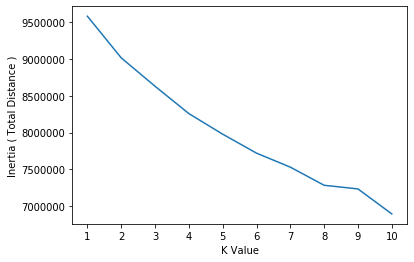

In [56]:
#adapted from https://medium.com/analytics-vidhya/choosing-the-best-k-value-for-k-means-clustering-d8b4616f8b86

#IMPORT LIBRARIES
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


if 'DELAY_BUCKET' in df_delay:
    y_kmeans = df_delay['DELAY_BUCKET'].values
    X_kmeans = df_delay.iloc[:,:-1].values

#scale data
scaler = StandardScaler()
scaler.fit(X_kmeans)
X_kmeans = scaler.transform(X_kmeans)

#Create a function that calculates Inertia for n times
#We will sweep through 1 to n to find the optimal cluster number
def cluster_variance(n):
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(1,n+1)]    
    
    for i in range(1,n+1):
        variance=0
        model=KMeans(n_clusters=i,random_state=123,verbose=2).fit(X_kmeans)
        kmeans.append(model)
        variances.append(model.inertia_)
        
    return variances,K,n
variances,K,n=cluster_variance(10)

plt.plot(K,variances)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(1,n+1)])
plt.show()

Our intertia (SSE) values are very large, but we do see them continue to decrease from 1 through 10. Let's extend the run from 10-20 to see if we reach a plateau.

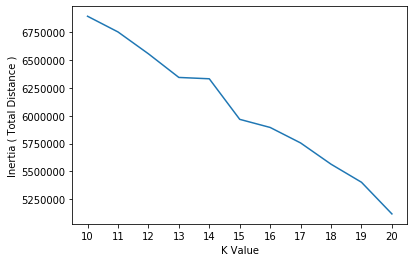

In [58]:
def cluster_variance(n):
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(10,n+1)]    
    
    for i in range(10,n+1):
        variance=0
        model=KMeans(n_clusters=i,random_state=123).fit(X_kmeans)
        kmeans.append(model)
        variances.append(model.inertia_)
        
    return variances,K,n
variances,K,n=cluster_variance(20)

plt.plot(K,variances)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(10,n+1)])
plt.show()

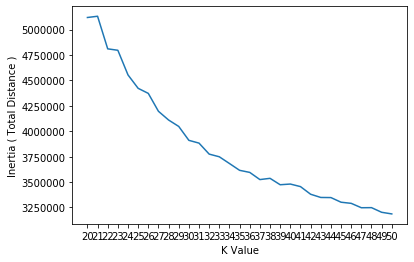

In [59]:
def cluster_variance(n):
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(20,n+1)]    
    
    for i in range(20,n+1):
        variance=0
        model=KMeans(n_clusters=i,random_state=123).fit(X_kmeans)
        kmeans.append(model)
        variances.append(model.inertia_)
        
    return variances,K,n
variances,K,n=cluster_variance(50)

plt.plot(K,variances)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(20,n+1)])
plt.show()

### Run on continuous data only

In [72]:
df_delay.head()

,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAXI_OUT,SCHEDULED_TIME,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,DESTINATION_AIRPORT_encode,TAIL_NUMBER_encode,AIRLINE_CODE_AS,AIRLINE_CODE_B6,AIRLINE_CODE_DL,AIRLINE_CODE_EV,AIRLINE_CODE_F9,AIRLINE_CODE_MQ,AIRLINE_CODE_NK,AIRLINE_CODE_OO,AIRLINE_CODE_UA,AIRLINE_CODE_US,AIRLINE_CODE_VX,AIRLINE_CODE_WN,SCHED_DEPARTURE_TIME_morning,SCHED_DEPARTURE_TIME_afternoon,SCHED_DEPARTURE_TIME_evening,SCHED_ARRIVAL_TIME_morning,SCHED_ARRIVAL_TIME_afternoon,SCHED_ARRIVAL_TIME_evening,DISTANCE_BUCKET_Medium,DISTANCE_BUCKET_Long,weather_main_Clouds,weather_main_Drizzle,weather_main_Dust,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Snow,weather_main_Thunderstorm,ORIGIN_AIRPORT_DFW,DELAY_BUCKET
0,1,1,4,1057,15.0,161,35.11,1031,66,4.7,20,0.0,0.0,0.0,0.0,90,804,90,581,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,4
1,1,1,4,72,18.0,145,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,83,1392,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1
2,1,1,4,1100,33.0,190,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,78,716,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
3,1,1,4,925,13.0,238,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,100,1554,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
4,1,1,4,972,56.0,159,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,44,1443,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1


In [73]:
#subset to continuous only
cont = ['TAXI_OUT', 'SCHEDULED_TIME', 'temp', 'pressure', 'humidity', 'wind_speed', 
       'wind_deg', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h', 'clouds_all']
X_cont = df_delay[cont].values

#scale data
scaler.fit(X_cont)
X_cont = scaler.transform(X_cont)

Initialization complete
Iteration 0, inertia 3969817.4492285857.
Iteration 1, inertia 2346635.999999931.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4007977.8449123404.
Iteration 1, inertia 2346635.999999931.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3299497.7727639745.
Iteration 1, inertia 2346635.999999931.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3280034.954067578.
Iteration 1, inertia 2346635.999999931.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3281380.629651547.
Iteration 1, inertia 2346635.999999931.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3159210.085880805.
Iteration 1, inertia 2346635.999999931.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3104438.328067319.
Iteration 1, inertia 2346635.9999

Iteration 16, inertia 2088371.2781257245
Iteration 17, inertia 2087705.4351870662
Iteration 18, inertia 2086994.3326540308
Iteration 19, inertia 2086346.2893075228
Iteration 20, inertia 2085950.4804588102
Iteration 21, inertia 2085746.7509715552
Iteration 22, inertia 2085643.787965774
Iteration 23, inertia 2085591.6940675436
Iteration 24, inertia 2085565.819139467
Converged at iteration 24: center shift 6.71281285114967e-05 within tolerance 0.00010000000000002558.
Initialization complete
Iteration 0, inertia 2686149.88636579
Iteration 1, inertia 2119250.398443186
Iteration 2, inertia 2094580.744498222
Iteration 3, inertia 2088064.1238462473
Iteration 4, inertia 2086393.7122147642
Iteration 5, inertia 2085801.5021851342
Iteration 6, inertia 2085640.1099043821
Iteration 7, inertia 2085587.899980789
Iteration 8, inertia 2085564.8795950515
Converged at iteration 8: center shift 7.341502261997633e-05 within tolerance 0.00010000000000002558.
Initialization complete
Iteration 0, inertia 30626

Iteration 7, inertia 1929867.9353180095
Iteration 8, inertia 1929258.2204138725
Iteration 9, inertia 1928571.6313531152
Iteration 10, inertia 1927727.7608046888
Iteration 11, inertia 1927126.557243832
Iteration 12, inertia 1926458.9964510666
Iteration 13, inertia 1925729.29376108
Iteration 14, inertia 1924994.8694812837
Iteration 15, inertia 1924126.0257404677
Iteration 16, inertia 1923034.0222081
Iteration 17, inertia 1921842.9253580752
Iteration 18, inertia 1920722.0693848059
Iteration 19, inertia 1919728.2544927811
Iteration 20, inertia 1918651.5880368606
Iteration 21, inertia 1917746.152336379
Iteration 22, inertia 1917006.1171799637
Iteration 23, inertia 1916335.2276986435
Iteration 24, inertia 1915648.5133351728
Iteration 25, inertia 1915024.953151624
Iteration 26, inertia 1914643.206093629
Iteration 27, inertia 1914465.9510190962
Iteration 28, inertia 1914377.531090521
Iteration 29, inertia 1914331.53246503
Iteration 30, inertia 1914308.5906433256
Converged at iteration 30: cent

Iteration 0, inertia 2378719.0761385597
Iteration 1, inertia 1802607.1785511512
Iteration 2, inertia 1735768.5733999126
Iteration 3, inertia 1711825.9270396053
Iteration 4, inertia 1704533.5829908208
Iteration 5, inertia 1702351.3773315938
Iteration 6, inertia 1701284.2893169485
Iteration 7, inertia 1700620.9101977518
Iteration 8, inertia 1700289.1430898919
Iteration 9, inertia 1700086.4347774773
Iteration 10, inertia 1699966.492868207
Iteration 11, inertia 1699903.9518783882
Iteration 12, inertia 1699880.8347494628
Iteration 13, inertia 1699870.5091973287
Converged at iteration 13: center shift 6.081793370350464e-05 within tolerance 0.00010000000000002558.
Initialization complete
Iteration 0, inertia 2347668.762094003
Iteration 1, inertia 1880779.2174790087
Iteration 2, inertia 1833721.8360665618
Iteration 3, inertia 1785032.3183089125
Iteration 4, inertia 1756946.1541440957
Iteration 5, inertia 1749570.0127721666
Iteration 6, inertia 1748353.1949905206
Iteration 7, inertia 1748089.61

Iteration 9, inertia 1642716.471695616
Iteration 10, inertia 1641616.9102790407
Iteration 11, inertia 1640775.46811275
Iteration 12, inertia 1640110.7702320605
Iteration 13, inertia 1639523.5192960347
Iteration 14, inertia 1639062.9013429908
Iteration 15, inertia 1638660.8194585475
Iteration 16, inertia 1638320.5210866274
Iteration 17, inertia 1638030.5893264292
Iteration 18, inertia 1637781.6297764825
Iteration 19, inertia 1637562.5385134534
Iteration 20, inertia 1637377.6895487276
Iteration 21, inertia 1637243.878843369
Iteration 22, inertia 1637159.534020647
Iteration 23, inertia 1637110.182753707
Iteration 24, inertia 1637078.3159356397
Iteration 25, inertia 1637055.1322932194
Iteration 26, inertia 1637039.1729524795
Iteration 27, inertia 1637028.4308311557
Converged at iteration 27: center shift 9.69478996649727e-05 within tolerance 0.00010000000000002558.
Initialization complete
Iteration 0, inertia 2162243.587270692
Iteration 1, inertia 1681800.344436486
Iteration 2, inertia 165

Initialization complete
Iteration 0, inertia 1934017.9359062512
Iteration 1, inertia 1573249.0079225048
Iteration 2, inertia 1550476.8876979167
Iteration 3, inertia 1536136.7489632785
Iteration 4, inertia 1526787.6184280384
Iteration 5, inertia 1519293.7053784719
Iteration 6, inertia 1512240.9077088484
Iteration 7, inertia 1503806.4680388772
Iteration 8, inertia 1495993.0921007977
Iteration 9, inertia 1490506.3581033158
Iteration 10, inertia 1488016.0047372167
Iteration 11, inertia 1486844.1984200024
Iteration 12, inertia 1486109.142827322
Iteration 13, inertia 1485498.7140278874
Iteration 14, inertia 1484942.7077413509
Iteration 15, inertia 1484414.2477518246
Iteration 16, inertia 1483829.7202989024
Iteration 17, inertia 1483161.0026791226
Iteration 18, inertia 1482308.2008311325
Iteration 19, inertia 1481308.1631978014
Iteration 20, inertia 1480338.9056045406
Iteration 21, inertia 1479200.2995677027
Iteration 22, inertia 1477990.3849174485
Iteration 23, inertia 1476631.72989186
Itera

Iteration 20, inertia 1458465.2439607906
Iteration 21, inertia 1458438.766739337
Iteration 22, inertia 1458417.4305100462
Iteration 23, inertia 1458393.0579356365
Iteration 24, inertia 1458367.506329252
Iteration 25, inertia 1458349.4133454314
Iteration 26, inertia 1458337.7600780928
Converged at iteration 26: center shift 9.801933836965738e-05 within tolerance 0.00010000000000002558.
Initialization complete
Iteration 0, inertia 1993742.1992474275
Iteration 1, inertia 1509000.591375629
Iteration 2, inertia 1445208.1541001585
Iteration 3, inertia 1419320.2303041206
Iteration 4, inertia 1412077.0812730263
Iteration 5, inertia 1410031.170224698
Iteration 6, inertia 1409395.4466033466
Iteration 7, inertia 1409208.2014466696
Iteration 8, inertia 1409137.9263823486
Iteration 9, inertia 1409116.9730582596
Converged at iteration 9: center shift 8.08004842990722e-05 within tolerance 0.00010000000000002558.
Initialization complete
Iteration 0, inertia 1934231.9129714584
Iteration 1, inertia 1623

Iteration 9, inertia 1389107.796016723
Iteration 10, inertia 1388850.209184457
Iteration 11, inertia 1388677.1679701922
Iteration 12, inertia 1388546.4978403037
Iteration 13, inertia 1388449.4243345056
Iteration 14, inertia 1388379.5489942443
Iteration 15, inertia 1388335.5845109276
Iteration 16, inertia 1388306.541118754
Iteration 17, inertia 1388286.7420975908
Iteration 18, inertia 1388272.5717378475
Iteration 19, inertia 1388262.7000332163
Converged at iteration 19: center shift 7.759290421923959e-05 within tolerance 0.00010000000000002558.
Initialization complete
Iteration 0, inertia 1989554.2625263145
Iteration 1, inertia 1717706.6187194781
Iteration 2, inertia 1672527.0517501365
Iteration 3, inertia 1656446.1312581685
Iteration 4, inertia 1647309.7270454539
Iteration 5, inertia 1632718.1339014333
Iteration 6, inertia 1608448.0912910227
Iteration 7, inertia 1581954.6064362552
Iteration 8, inertia 1559461.3139291715
Iteration 9, inertia 1527405.2855706501
Iteration 10, inertia 1505

Iteration 17, inertia 1359658.1881256506
Iteration 18, inertia 1359295.5587913268
Iteration 19, inertia 1359016.8757061434
Iteration 20, inertia 1358799.7821858947
Iteration 21, inertia 1358616.3299172428
Iteration 22, inertia 1358470.1506945312
Iteration 23, inertia 1358333.3413777878
Iteration 24, inertia 1358196.961119379
Iteration 25, inertia 1358038.317513354
Iteration 26, inertia 1357833.4204797074
Iteration 27, inertia 1357549.7038174707
Iteration 28, inertia 1357155.8678186499
Iteration 29, inertia 1356640.363151078
Iteration 30, inertia 1355926.0881519422
Iteration 31, inertia 1354846.8720149589
Iteration 32, inertia 1353281.8621236763
Iteration 33, inertia 1350996.5073984023
Iteration 34, inertia 1347639.5674978169
Iteration 35, inertia 1342657.9800843818
Iteration 36, inertia 1337053.2585603495
Iteration 37, inertia 1334187.5196059812
Iteration 38, inertia 1332904.533095416
Iteration 39, inertia 1332211.1677525768
Iteration 40, inertia 1331702.2398864275
Iteration 41, inerti

Iteration 54, inertia 1303359.4148518324
Iteration 55, inertia 1301066.270023901
Iteration 56, inertia 1298335.7299919892
Iteration 57, inertia 1297966.5452144512
Iteration 58, inertia 1297958.3661910414
Converged at iteration 58: center shift 3.63438450040421e-05 within tolerance 0.00010000000000002558.
Initialization complete
Iteration 0, inertia 1683117.3234278217
Iteration 1, inertia 1386523.0476699022
Iteration 2, inertia 1374588.964627403
Iteration 3, inertia 1370207.1192992816
Iteration 4, inertia 1367780.0378583528
Iteration 5, inertia 1366512.086873211
Iteration 6, inertia 1365732.2336186485
Iteration 7, inertia 1365156.3192628222
Iteration 8, inertia 1364725.1290215356
Iteration 9, inertia 1364398.7258932637
Iteration 10, inertia 1364165.6611022064
Iteration 11, inertia 1364008.0315400437
Iteration 12, inertia 1363892.1547788507
Iteration 13, inertia 1363806.9988458303
Iteration 14, inertia 1363734.6657973155
Iteration 15, inertia 1363670.54341804
Iteration 16, inertia 136359

Iteration 29, inertia 1272864.4446551828
Iteration 30, inertia 1272534.1260472187
Iteration 31, inertia 1272290.772162035
Iteration 32, inertia 1272163.0745256727
Iteration 33, inertia 1272086.0086069524
Iteration 34, inertia 1272025.2928668447
Iteration 35, inertia 1271974.322493293
Iteration 36, inertia 1271932.299160903
Iteration 37, inertia 1271879.15687897
Iteration 38, inertia 1271797.6023788883
Iteration 39, inertia 1271684.5435977522
Iteration 40, inertia 1271593.7565054344
Iteration 41, inertia 1271529.2558149158
Iteration 42, inertia 1271476.7625371632
Iteration 43, inertia 1271409.348959338
Iteration 44, inertia 1271336.7969264633
Iteration 45, inertia 1271268.699288675
Iteration 46, inertia 1271213.711268799
Iteration 47, inertia 1271174.1038572134
Iteration 48, inertia 1271138.3980235823
Iteration 49, inertia 1271094.0434901142
Iteration 50, inertia 1271032.4571234982
Iteration 51, inertia 1270958.461648919
Iteration 52, inertia 1270884.9199014008
Iteration 53, inertia 127

Initialization complete
Iteration 0, inertia 1740828.9834273334
Iteration 1, inertia 1405215.7327966788
Iteration 2, inertia 1368183.500114124
Iteration 3, inertia 1352337.440438695
Iteration 4, inertia 1346731.8362067624
Iteration 5, inertia 1342936.4608844991
Iteration 6, inertia 1339846.6502432225
Iteration 7, inertia 1336725.1786757915
Iteration 8, inertia 1334615.417230411
Iteration 9, inertia 1333411.727538717
Iteration 10, inertia 1332673.5551342762
Iteration 11, inertia 1332164.9409661673
Iteration 12, inertia 1331754.6082623797
Iteration 13, inertia 1331443.1006688045
Iteration 14, inertia 1331196.259506187
Iteration 15, inertia 1330941.4872308818
Iteration 16, inertia 1330563.801641671
Iteration 17, inertia 1329892.255416732
Iteration 18, inertia 1328667.5616011037
Iteration 19, inertia 1326460.2975795264
Iteration 20, inertia 1323618.7843843116
Iteration 21, inertia 1320202.659883674
Iteration 22, inertia 1315450.456494497
Iteration 23, inertia 1309243.4791462102
Iteration 2

Iteration 7, inertia 1243414.8040603732
Iteration 8, inertia 1240797.2026922447
Iteration 9, inertia 1238965.233172771
Iteration 10, inertia 1237359.4448112315
Iteration 11, inertia 1235523.6110909067
Iteration 12, inertia 1232401.7167822695
Iteration 13, inertia 1224027.5497323878
Iteration 14, inertia 1203276.518175175
Iteration 15, inertia 1180895.4966698096
Iteration 16, inertia 1164526.823219352
Iteration 17, inertia 1144400.031291497
Iteration 18, inertia 1131369.2265689394
Iteration 19, inertia 1129618.9116904894
Iteration 20, inertia 1128905.6777123942
Iteration 21, inertia 1128287.7679315463
Iteration 22, inertia 1127682.240656999
Iteration 23, inertia 1127223.063933916
Iteration 24, inertia 1126864.7430332424
Iteration 25, inertia 1126589.690113841
Iteration 26, inertia 1126413.289015164
Iteration 27, inertia 1126265.8361341946
Iteration 28, inertia 1126136.0938978286
Iteration 29, inertia 1125968.9518494532
Iteration 30, inertia 1125814.8298081465
Iteration 31, inertia 11257

Initialization complete
Iteration 0, inertia 1526997.8637208217
Iteration 1, inertia 1242524.2658677485
Iteration 2, inertia 1201091.354764741
Iteration 3, inertia 1176809.6767524004
Iteration 4, inertia 1163112.2702473009
Iteration 5, inertia 1156592.8320915902
Iteration 6, inertia 1152746.033752534
Iteration 7, inertia 1149961.8778733364
Iteration 8, inertia 1147902.12047695
Iteration 9, inertia 1146306.4087065265
Iteration 10, inertia 1145185.1092534687
Iteration 11, inertia 1144446.5176003317
Iteration 12, inertia 1143859.3255772407
Iteration 13, inertia 1143466.941639615
Iteration 14, inertia 1143204.8067276094
Iteration 15, inertia 1142983.9183377645
Iteration 16, inertia 1142813.6053817663
Iteration 17, inertia 1142702.3992556527
Iteration 18, inertia 1142634.439494336
Iteration 19, inertia 1142584.3093745383
Iteration 20, inertia 1142536.460646628
Iteration 21, inertia 1142501.60914672
Iteration 22, inertia 1142476.8217967378
Iteration 23, inertia 1142457.938539047
Iteration 24

Iteration 17, inertia 1145264.0266117656
Iteration 18, inertia 1145022.6085923773
Iteration 19, inertia 1144929.2458001133
Iteration 20, inertia 1144911.5222907616
Iteration 21, inertia 1144903.2664284345
Iteration 22, inertia 1144897.358684983
Iteration 23, inertia 1144892.382419513
Converged at iteration 23: center shift 9.109489228840506e-05 within tolerance 0.00010000000000002558.
Initialization complete
Iteration 0, inertia 1497592.8098423015
Iteration 1, inertia 1220757.8446000258
Iteration 2, inertia 1193075.1337227323
Iteration 3, inertia 1176996.8765448984
Iteration 4, inertia 1169180.9940317164
Iteration 5, inertia 1165902.915786519
Iteration 6, inertia 1164197.5566933611
Iteration 7, inertia 1163285.9839983252
Iteration 8, inertia 1162742.036902082
Iteration 9, inertia 1162388.6758759136
Iteration 10, inertia 1162151.034156024
Iteration 11, inertia 1161978.491163823
Iteration 12, inertia 1161840.001546054
Iteration 13, inertia 1161717.8800390034
Iteration 14, inertia 1161605

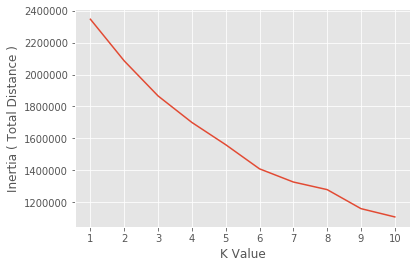

In [74]:
def cluster_variance(n):
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(1,n+1)]    
    
    for i in range(1,n+1):
        variance=0
        model=KMeans(n_clusters=i,random_state=123,verbose=2).fit(X_cont)
        kmeans.append(model)
        variances.append(model.inertia_)
        
    return variances,K,n
variances,K,n=cluster_variance(10)

plt.plot(K,variances)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(1,n+1)])
plt.show()

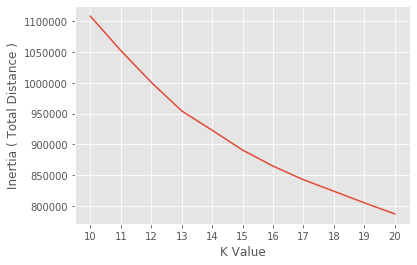

In [75]:
def cluster_variance(n):
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(10,n+1)]    
    
    for i in range(10,n+1):
        variance=0
        model=KMeans(n_clusters=i,random_state=123).fit(X_cont)
        kmeans.append(model)
        variances.append(model.inertia_)
        
    return variances,K,n
variances,K,n=cluster_variance(20)

plt.plot(K,variances)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(10,n+1)])
plt.show()

In [ ]:
def cluster_variance(n):
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(20,n+1)]    
    
    for i in range(20,n+1):
        variance=0
        model=KMeans(n_clusters=i,random_state=123).fit(X_cont)
        kmeans.append(model)
        variances.append(model.inertia_)
        
    return variances,K,n
variances,K,n=cluster_variance(50)

plt.plot(K,variances)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(20,n+1)])
plt.show()

# Test/Train Split

In [47]:
# Create X and y for delay data set
if 'DELAY_BUCKET' in df_delay:
    y_del = df_delay['DELAY_BUCKET'].values
    X_del = df_delay.iloc[:,:-1].values

In [48]:
# Oversample using SMOTE
oversample = SMOTE()
X_del_smote, y_del_smote = oversample.fit_resample(X_del, y_del)

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

for train_index, test_index in sss.split(X_del_smote, y_del_smote):
    X_train_del_smote, X_test_del_smote = X_del_smote[train_index], X_del_smote[test_index]
    y_train_del_smote, y_test_del_smote = y_del_smote[train_index], y_del_smote[test_index]

print("Split on Oversampled Data:\n")
print('Training Features Shape:', X_train_del_smote.shape)
print('Training Labels Shape:', y_train_del_smote.shape)
print('Testing Features Shape:', X_test_del_smote.shape)
print('Testing Labels Shape:', y_test_del_smote.shape)

Split on Oversampled Data:

Training Features Shape: (441356, 49)
Training Labels Shape: (441356,)
Testing Features Shape: (110339, 49)
Testing Labels Shape: (110339,)


## Modeling and Evaluation 1

> Train and adjust parameters

In [ ]:
#adapted from https://medium.com/analytics-vidhya/choosing-the-best-k-value-for-k-means-clustering-d8b4616f8b86

### Best Performing Classifier Model from Lab 2

In Lab 2, we determined that running KNN on the oversampled data using SMOTE with Grid Search was our best performing model. We've included it here as a baseline for our clustering models.

In [23]:
%%time
# # https://realpython.com/knn-python/
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Create KNN Classifier
parameters = {
     "n_neighbors": list(range(1,20,2)),
     "weights": ["uniform", "distance"],
 }
gridsearch = GridSearchCV(KNeighborsClassifier(), 
                          parameters, 
                          cv = 10,
                          n_jobs = -1,
                          scoring = 'f1_weighted')

gridsearch.fit(X_train_del_smote, y_train_del_smote)
gridsearch.best_params_

Wall time: 1h 18min 28s


{'n_neighbors': 1, 'weights': 'uniform'}

In [ ]:
test_preds_grid2 = gridsearch.predict(X_test_del_smote)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test_del_smote, test_preds_grid2))
print('Weighted Precision: {:.2f}'.format(precision_score(y_test_del_smote, test_preds_grid2, average = 'weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_del_smote, test_preds_grid2, average = 'weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_del_smote, test_preds_grid2, average = 'weighted')))

In [ ]:
# Save and run model with K=1 and pull metrics
knn_delay = KNeighborsClassifier(n_neighbors = 1, weights = 'uniform')
knn_delay.fit(X_train_del_smote, y_train_del_smote)
y_pred_knn_del = knn_delay.predict(X_test_del_smote)

## Modeling and Evaluation 2
Jump to [top](#Rubric)

> Evaluate and compare

## Modeling and Evaluation 3
Jump to [top](#Rubric)

> Visualize results

## Modeling and Evaluation 4
Jump to [top](#Rubric)

> Summarise the ramifications

# Deployment
Jump to [top](#Rubric)

# Exceptional Work
Jump to [top](#Rubric)